In [0]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

##Sorting the dataset to get same values every time

In [0]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

##Fetching the Dataset

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True) # fetch_openml() returns targets as strings
    mnist.target = mnist.target.astype(np.int8) 
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [0]:
X,y = mnist['data'],mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

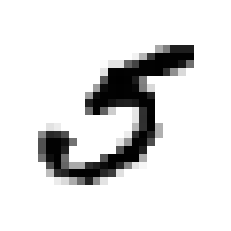

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,interpolation="nearest")
plt.axis("off")

plt.show()


In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

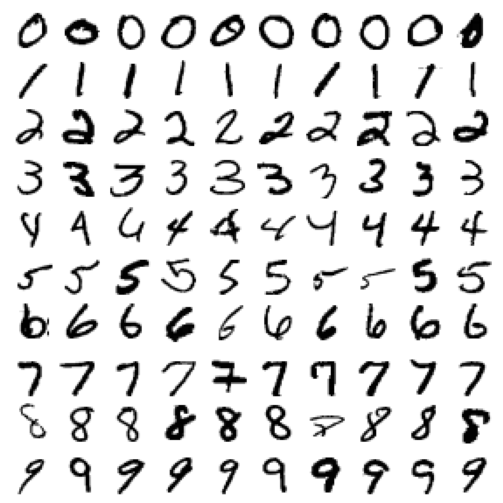

In [65]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

##Separating the Dataset

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np
shuffle_index = np.random.permutation(60000) #shuffling order of dataset to increase accuracy
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

##Adding a binary classifier to identify a digit

In [0]:
# either an image is that particular number or not 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier
# since few hyperparamters will have different default value in future versions of scikit therefore a warning is issued if not set explicitly
# thus we set max_iter = 5, tol = -np.infty
sgd_clf = SGDClassifier(max_iter = 5, tol = -np.infty, random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
#testing accuracy of model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

##Measuring accuracy using Stratified K Folds

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96225
0.9645
0.94765


#Classifying image as not 5

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1), dtype = bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,y_train_5, cv = 3, scoring = 'accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [0]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

##Creating confusion matrix to measure accuracy

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# first row denotes negative class and second row consists of positive class

array([[53417,  1162],
       [ 1350,  4071]])

In [0]:
y_train_perfect_predictions = y_train_5 

In [21]:
from sklearn.metrics import confusion_matrix
# for a perfect classifier there are no false positives and true negatives 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [23]:
 4071/ (4071 + 1162) #TP/(FP+TP)

0.7779476399770686

In [24]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

In [25]:
4071/ (4071 + 1350) #TP/(TP+FN)

0.7509684560044272

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [0]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [28]:
y_some_digit_pred

array([ True])

## Calculating the F1 score of the model which measures how similar precision and recall are

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

#Setting the threshold higher to increase precision(default = 0)

In [30]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [32]:
y_scores.shape

(60000,)

## Plotting precision recall curve

In [0]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

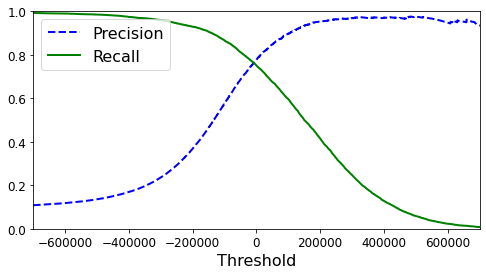

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) #b-- specifies line type and color
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize = 16)
    plt.legend(loc="upper left", fontsize = 16)
    plt.ylim([0, 1])

#calling the function and 
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [0]:
y_train_pred_90 = y_scores > 70000 #around 90% precision inferred by graph

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

## Plotting graph of recall vs precision(better)

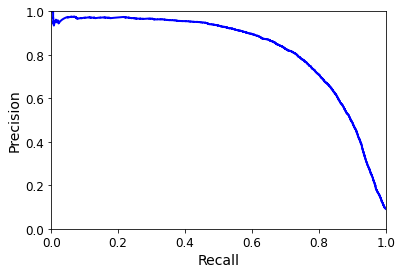

In [38]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, "b-", linewidth = 2)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.axis([0,1,0,1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

##Plotting the ROC Curve(reciever operating characteristic)

In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

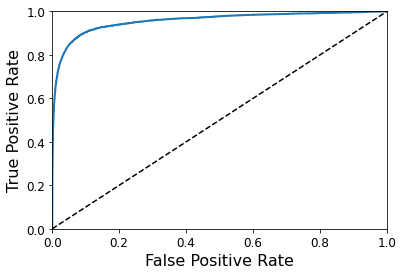

In [40]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2)
  plt.plot([0,1],[0,1],'k--') #dotted line is for completely random classifier
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr,tpr)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score  # perfect classifier has auc == 1
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

## Using Random Forest Classifier instead of SGD

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [0]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

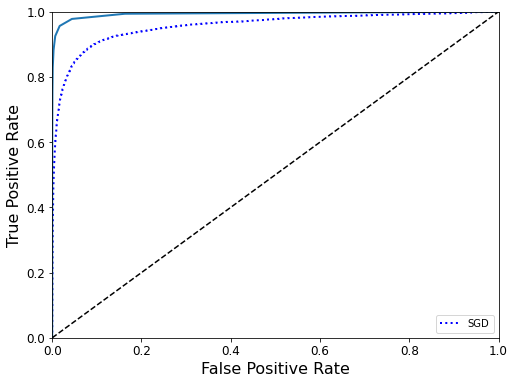

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest,label="Random Forest")
plt.legend(loc= "lower right")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

##Multiple Class Classification(Random Forests and Native Bayes Classifier)

In [48]:
sgd_clf.fit(X_train,y_train) #y_train and not y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [49]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores #prints 10 as OvA also known as one vs the rest

# 5 has greatest score

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [50]:
np.argmax(some_digit_scores) #outputs max of array of some_digit_scores == correct prediction

5

In [51]:
sgd_clf.classes_ #returns array of classes made

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [52]:
# to force the SGD to use OvO strategy
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol = -np.infty, random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
len(ovo_clf.estimators_) 
# classes_ will return 10 as OneVsOneClassifier is the strategy passed to SGD which will have 10 classes
#estimators_ will denote the number of inter dependent relations between the classes

45

In [54]:
# Training Random Forest Classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [55]:
# displaying proba of all classes
forest_clf.predict_proba([some_digit]) # 5 has max proba

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [56]:
# getting accuracy of SGD on entire dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.9091 , 0.90955, 0.9062 ])

## Creating Confusion Matrix for all 10 numbers 

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

# real vs predicted (X vs y)

array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]])

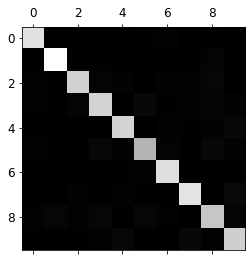

In [58]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()
# classified correctly as all numbers are on correct diagonal

In [0]:
# dividing every value in matrix by corresponding number of values in class to compare error rat
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

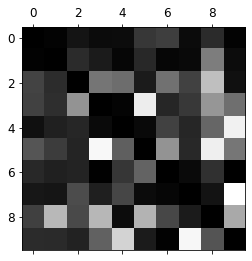

In [60]:
# plotting relative to error rate
np.fill_diagonal(norm_conf_mx, 0) # assigning 0 to actual outputs
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

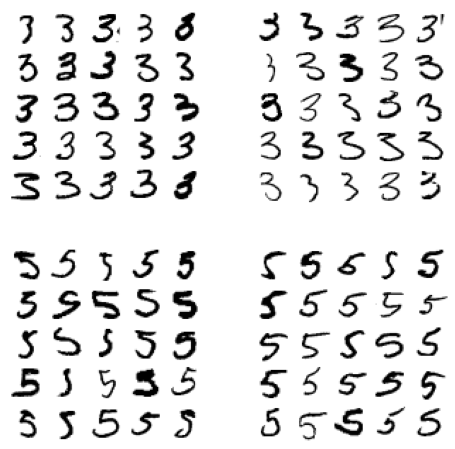

In [66]:
# to see digits classified

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [61]:
# to get predictions having more than one features
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 != 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [62]:
knn_clf.predict([some_digit]) # getting predictions on basis of arguments

array([[False,  True]])

In [0]:
# Cell will take toooo long to execute 
 
y_train_knn_clf = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)
f1_score(y_multilabel, y_train_knn_clf, average = 'macro')

## Multioutput Classification

In [0]:
# it is multi classification where each label can be a multiclass
# eg: cleaning noisy data from MNIST image
# it is multioutput as there are multiple labels(28x28) and each can have different pixel intensities(0,255)

# creating training and test sets and adding noise

noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
some_index = 5500

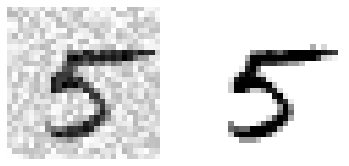

In [69]:
# plotting img with noise vs without
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

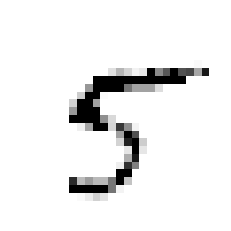

In [70]:
# Training the test data to clean the image and plotting

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Dummy(Random) Classifier

In [71]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train,y_train, cv = 3, method = 'predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


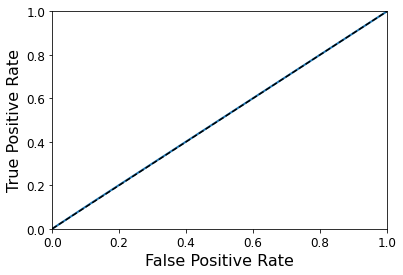

In [72]:
fprr, tprr, thresholdr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

In [73]:
roc_auc_score(y_train_5, y_scores_dmy) # bad prediction for Random Classifier

0.5008569494564384